In [104]:
import math, copy, random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import seaborn as sns
import mealpy
from mealpy.swarm_based import NMRA, MPA, ARO

In [105]:
class Sensors:
    def __init__(self,id, type, x, y, x_e = 0, y_e = 0, energy = 10):
        self.id = id
        self.type = type
        self.x = x
        self.y = y
        self.x_e = x_e
        self.y_e = y_e
        self.energy = energy

In [106]:
error_overall = []

### Function to find virtual anchor nodes

In [107]:
def find_virtual_anchors(x,y,d):
    anchors=[]
    anchors.append([x+d*np.cos(np.pi/3),y+d*np.sin(np.pi/3)])
    anchors.append([x+d,y])
    anchors.append([x-d,y]);
    anchors.append([x+d*np.cos(np.pi/3),y-d*np.sin(np.pi/3)]);
    anchors.append([x-d*np.cos(np.pi/3),y-d*np.sin(np.pi/3)]);
    anchors.append([x-d*np.cos(np.pi/3),y+d*np.sin(np.pi/3)]);
    return anchors

### Function to elect new anchor node

In [108]:
def elect_anchor(anchor, sensor):
    maximum_energy = 0
    new_anchor = 0
    for i in range(len(sensor)):
        if sensor[i].type == 'target' and sensor[i].energy >= maximum_energy:
            maximum_energy = sensor[i].energy
            new_anchor = i
            
#     print(old_anchor)
    anchor = copy.deepcopy(sensor[new_anchor])
    anchor.type = 'anchor'
    del sensor[new_anchor]
    
    return anchor    

### Optimization Function

In [109]:
def Fun(x,y, anchors, target):
    f = 0
    for i in range(3):
        d = math.dist([target[0],target[1]], [anchors[i][0],anchors[i][1]])
        d1= math.dist([x,y],[anchors[i][0],anchors[i][1]])
        f +=  math.pow( abs(d1 - d),2)
    return f/3

### NMRA optimizer function

In [110]:
def NMRA_custom(maxIter,best,n,anchors,target,x,y, error_each_epoch):
    
    # Finding 2 Virtual Anchor nodes with shortest distance from target node

    d=math.dist([x,y],anchors[0]);
    virtual_anchors=find_virtual_anchors(anchors[0][0],anchors[0][1], d)
    va_dist=[]
    for j in range(len(virtual_anchors)):
        dist=math.dist([x,y],[virtual_anchors[j][0],virtual_anchors[j][1]])
        l=[dist,j]
        va_dist.append(l)
    va_dist.sort()
    idx1,idx2=va_dist[0][1],va_dist[1][1]
    va1,va2=virtual_anchors[idx1],virtual_anchors[idx2]
    anchors.append(va1)
    anchors.append(va2)
    
    # Calculating centroid
    centroid_x,centroid_y=(va1[0]+va2[0]+anchors[0][0])/3,(va1[1]+va2[1]+anchors[0][1])/3
    x_lb,x_ub,y_lb,y_ub=centroid_x-1,centroid_x+1,centroid_y-1,centroid_y+1
    
    rats=[]
    # 24
    workers=n-n//5 
    # 6
    breeders=n//5
    fitness=[]
    bp=0.5
   
    # First rat is at centroid
    rats.append([centroid_x,centroid_y])
    fitness.append(Fun(centroid_x,centroid_y,anchors,target))
    # Initializing random rats and calculating their fitness
    for i in range(n-1):
        x1=x_lb+np.random.random()*(x_ub-x_lb)
        y1=y_lb+np.random.random()*(y_ub-y_lb)
        rats.append([x1,y1])
        fitness.append(Fun(x1,y1,anchors,target))
    
    sorted_fitness = []
    for i in range(n):
        l = [fitness[i],i]
        sorted_fitness.append(l)
    sorted_fitness.sort()
    
    
    for itr in range(maxIter):
        S = copy.deepcopy(rats)
        ratBest=rats[sorted_fitness[0][1]]
        
        # Workers phase
        
        for i in range(breeders, n):
            ab = []
            for j in range(breeders, n):
                ab.append(sorted_fitness[j][1])
            idx = sorted_fitness[i][1]
            lmda = np.random.random()
            random.shuffle(ab)
            # print(lmda)
            S[idx][0] = S[idx][0] + lmda * (S[ab[0]][0] - S[ab[1]][0])
            S[idx][1] = S[idx][1] + lmda * (S[ab[0]][1] - S[ab[1]][1])
            # Calculating and updating new fitness and rat's coordinates
            fnew = Fun(S[idx][0], S[idx][1], anchors, target)
            if fnew < fitness[idx]:
                fitness[idx] = fnew
                rats[idx]= S[idx]
        
        # Breeders phase
        for i in range(breeders):
            if np.random.random() > bp:
                lmda = np.random.random()
                idx = sorted_fitness[i][1]
                
                S[idx][0] = (1-lmda)*S[idx][0] + lmda*(ratBest[0] - S[idx][0])
                S[idx][1] = (1-lmda)*S[idx][1] + lmda*(ratBest[1] - S[idx][1])
                fnew = Fun(S[idx][0], S[idx][1], anchors, target)
                if fnew < fitness[idx]:
                    fitness[idx] = fnew
                    rats[idx]= S[idx]
                    
        # Updating sorted fitness list
        sorted_fitness.clear()
        for i in range(n):
            l = [fitness[i],i]
            sorted_fitness.append(l)
        sorted_fitness.sort()
        idx = sorted_fitness[0][1]
        error_each_epoch.append(math.dist(rats[idx], target))
        
        # Uncomment this to show the process
#         if itr==0 or itr==10 or itr==20 or itr==39:
#             idx_graph=sorted_fitness[0][1]
#             r=np.array(rats)
#             an=np.array(anchors)
#             xr,yr=r.T
#             xa,ya=an.T
#             fig,ax=plt.subplots()
#             ax.set_xlim(0,15)
#             ax.set_ylim(0,15)
            
#             ax.scatter(xr,yr,marker='2',s=75,label="Mole Rats")
        
#             ax.scatter(xa[0], ya[0], marker = 'D', c = "slateblue",s=100,label="Anchor Node")
#             ax.scatter(xa[1], ya[1], marker = 'o', c = "teal",s=100,label="Virtual Anchor Node")
#             ax.scatter(xa[2], ya[2], marker = 'o', c = "teal",s=100)
#             ax.scatter(target[0],target[1], marker='^',s=100,label="Target Node",c="hotpink")
#             ax.scatter(rats[idx_graph][0],rats[idx_graph][1], marker='v',s=100,label="Estimated Position",c="orange")
#             plt.legend()
#             plt.show()
#         print(rats[idx_graph])
#         print(sorted_fitness[0][0])

    
    idr=sorted_fitness[0][1]
    #print(rats[idr])
    
    return rats[idr]

### Constants and deploying nodes

In [111]:
no_of_movements = 5
no_of_target_nodes = 20
anchor1 = [7.5,7.5]
target_nodes=[]
sensor = []
anchor = Sensors(0, 'anchor', 7.5, 7.5, 7.5, 7.5)
    
x_target=np.random.uniform(0,15,no_of_target_nodes)
y_target=np.random.uniform(0,15,no_of_target_nodes)

for i in range(no_of_target_nodes):
    s = Sensors(i+1, 'target', x_target[i], y_target[i])
    sensor.append(s)
# print(sensor)
    
    

In [112]:
predicted_C = []
original_C = []
curr_anchor = []
anchor_Energy = []

# Adding random mobility to the target nodes
for i in range(no_of_movements):
    error_this_movement = []
    predicted=[]
    original=[]
    anchor_Energy.append(anchor.energy)
    for i in range(len(sensor)):
        sensor[i].x+=0.1*random.uniform(-15,15)
        sensor[i].y+=0.1*random.uniform(-15,15)
        if sensor[i].x<0 or sensor[i].x>15:
            sensor[i].x=random.uniform(0,15)
        if sensor[i].y<0 or sensor[i].y>15:
            sensor[i].y=random.uniform(0,15)
        energy = sensor[i].energy - np.random.random()
        sensor[i].energy = energy

    
    
    for i in range(len(sensor)):
        # Mealpy
        d = math.dist([sensor[i].x,sensor[i].y], [anchor.x,anchor.y])
        virtual_anchors=find_virtual_anchors(anchor.x,anchor.y, d)
        va_dist=[]
        for j in range(len(virtual_anchors)):
            dist=math.dist([sensor[i].x,sensor[i].y],[virtual_anchors[j][0],virtual_anchors[j][1]])
            l=[dist,j]
            va_dist.append(l)
        va_dist.sort()
        idx1,idx2=va_dist[0][1],va_dist[1][1]
        va1,va2=virtual_anchors[idx1],virtual_anchors[idx2]
        
        # Calculating centroid
        centroid_x,centroid_y=(va1[0]+va2[0]+anchor.x)/3,(va1[1]+va2[1]+anchor.y)/3
        x_lb,x_ub,y_lb,y_ub=centroid_x-1,centroid_x+1,centroid_y-1,centroid_y+1

        error_each_epoch = []
        def fitness_function(sol):
            f = 0
            for i in range(3):
                d1= math.dist(sol,[anchor.x,anchor.y])
                f +=  math.pow( abs(d1 - d),2)
            return f/3

        problem = {
            "fit_func": fitness_function,
            "lb": [x_lb,y_lb],
            "ub": [x_ub,y_ub],
            "minmax": "min",
            "log_to": None,
            "save_population": True,
        }   

        epoch = 1000
        pop_size = 50
        pb = 0.5
        # model = NMRA.ImprovedNMRA(epoch, pop_size, pb)
        # model = MPA.OriginalMPA(epoch,pop_size)
        model = ARO.OriginalARO(epoch,pop_size)

        best_position, best_fitness = model.solve(problem)
        print(f"original: {[sensor[i].x,sensor[i].y]}")
        print(f"Solution: {best_position}, Fitness: {best_fitness}")
        # print(best_position)
        coordinates = best_position.tolist()
        # print(coordinates)
        # coordinates=NMRA_custom(60,3,30,[[anchor.x,anchor.y]],[sensor[i].x,sensor[i].y],sensor[i].x,sensor[i].y, error_each_epoch)
# #         print(coordinates)
        predicted.append(coordinates)
        original.append([sensor[i].x,sensor[i].y])
        sensor[i].x_e = coordinates[0]
        sensor[i].y_e = coordinates[1]
        error_this_movement.append(error_each_epoch)
    
    error_overall.append(error_this_movement)
    curr_anchor.append([anchor.x, anchor.y])
    predicted_C.append(predicted)
    original_C.append(original)
    
    if anchor.energy>=2:
        energy = anchor.energy - 10 * np.random.random()
        anchor.energy = energy
    if anchor.energy<2:
        anchor = elect_anchor(anchor, sensor)
        anchor.x = anchor.x_e
        anchor.y = anchor.y_e
    
print(len(predicted_C[0]),len(original_C[0]))

original: [11.65140864419963, 5.391516624651477]
Solution: [10.82808375  5.15588022], Fitness: 0.3427088469146213
original: [1.7078238080102752, 12.734799003808405]
Solution: [ 2.59639828 10.75374551], Fitness: 3.6952107976557955
original: [0.9379497152369752, 5.881385087628713]
Solution: [3.12063548 4.54892299], Fitness: 2.184039017645844
original: [10.12494719134793, 13.42466176573519]
Solution: [ 8.5        12.24129945], Fitness: 2.6716306753726875
original: [11.224315864042705, 8.507632601525042]
Solution: [10.42910939  9.61377182], Fitness: 0.060544017263084726
original: [9.684428954364462, 5.5618888189396465]
Solution: [9.96013739 5.92655511], Fitness: 0.0
original: [0.2406134330497003, 2.6199174599672914]
Solution: [2.12638882 3.97489441], Fitness: 5.384970734153806
original: [7.150615402420554, 9.28176623134995]
Solution: [8.5        9.01550668], Fitness: 4.930380657631324e-32
original: [7.949655617218674, 1.4084700324242703]
Solution: [6.5        2.97348484], Fitness: 2.168090

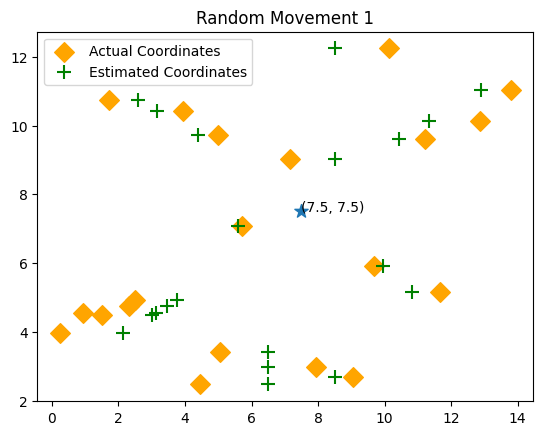

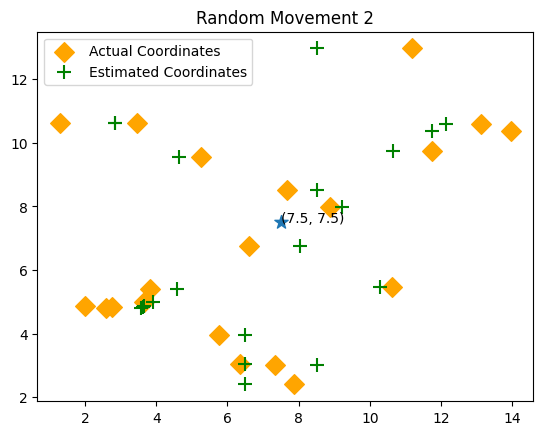

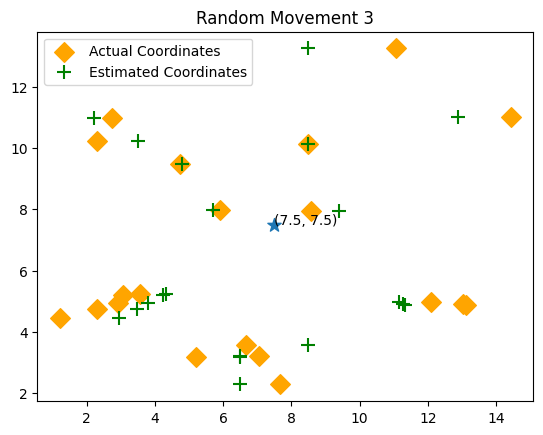

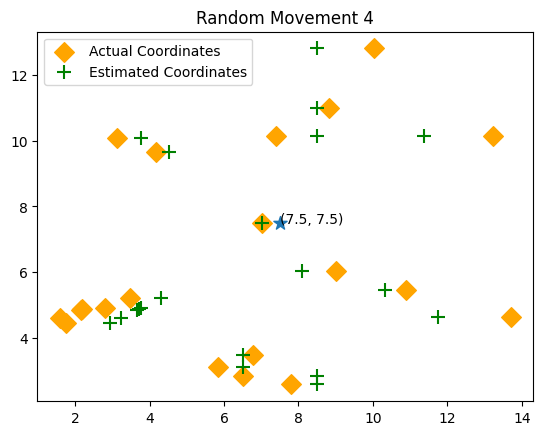

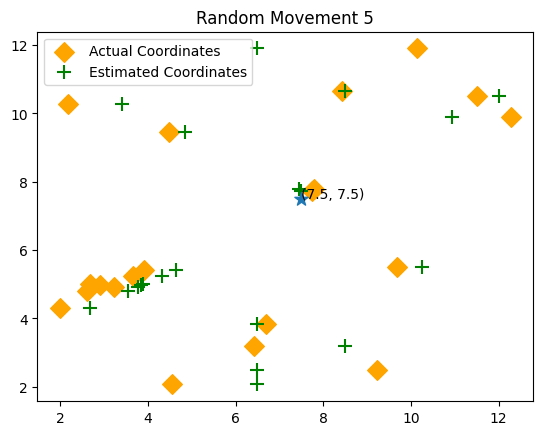

In [113]:
curr_anchor = np.array(curr_anchor)
anchor_x, anchor_y = curr_anchor.T
    
for i in range(no_of_movements):
    predicted = np.array(predicted_C[i])
    predicted_x, predicted_y = predicted.T

    original = np.array(original_C[i])
    original_x, original_y = original.T
      
    title = 'Random Movement '+ str(i +1)
    
    plt.title(title)
    plt.scatter(original_x, predicted_y, marker = 'D', s = 100, c = 'Orange', label = 'Actual Coordinates')
    plt.scatter(predicted_x, predicted_y, marker = '+', s = 100, c = 'green', label = 'Estimated Coordinates')
    plt.scatter(anchor_x[i],anchor_y[i],marker='*',s = 100)
    plt.text(anchor_x[i], anchor_y[i], '({}, {})'.format(round(anchor_x[i],2), round(anchor_y[i],2)))
    plt.legend()
    plt.show()



### Error Calculation

[1 2 3 4 5]


[Text(0.5, 0, 'Movement Number'),
 Text(0, 0.5, 'Error'),
 Text(0.5, 1.0, 'Errors vs Movement')]

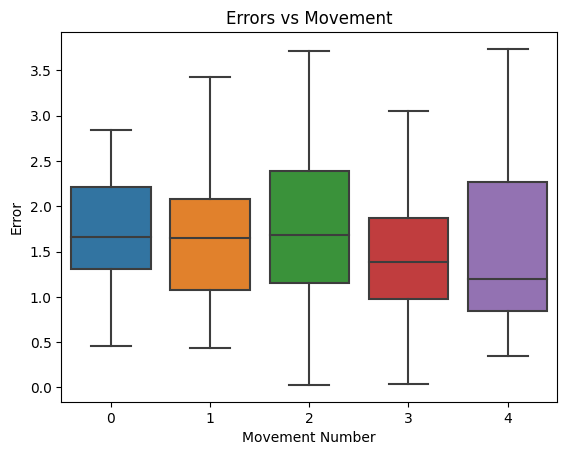

In [114]:
min_error = []
avg_error = []
max_error = []
error_movement=[]
xaxis = np.arange(1,no_of_movements+1)
print(xaxis)
for i in range(no_of_movements):
    error = []
    avg_e = 0
    no_of_target_nodes = len(predicted_C[i])
    for j in range(len(predicted_C[i])):
        e = math.dist(predicted_C[i][j], original_C[i][j])
        avg_e += e
        error.append(e)
    avg_e/=no_of_target_nodes
    
    max_e = max(error)
    min_e = min(error)
    error_movement.append(error)
    avg_error.append(avg_e)
    max_error.append(max_e)
    min_error.append(min_e)

# print(min_error)
# print(avg_error)
# print(max_error)
# print(error_movement)
# plt.bar(xaxis - 0.25, min_error, 0.25, label = 'Min Error')
# plt.bar(xaxis, max_error, 0.25 , label = 'Max Error')
# plt.bar(xaxis + 0.25, avg_error,0.25, label = 'average Error')
# plt.legend()
# plt.xlabel('No. of movements')
# plt.show()
ax = sns.boxplot(data=error_movement)
ax.set(xlabel="Movement Number", ylabel = "Error", title= "Errors vs Movement")


In [115]:
FA_avg_error = [2.3594, 3.0538, 2.4412, 3.136, 2.6024]
BBO_avg_error = [0.3838, 0.8227, 0.6926, 0.7984, 0.9317]
PSO_avg_error = [0.7048,1.1338,0.8236,0.5982, 0.7536]
HPSO_avg_error = [0.2449,0.3536,0.3338,0.3491,0.2209]

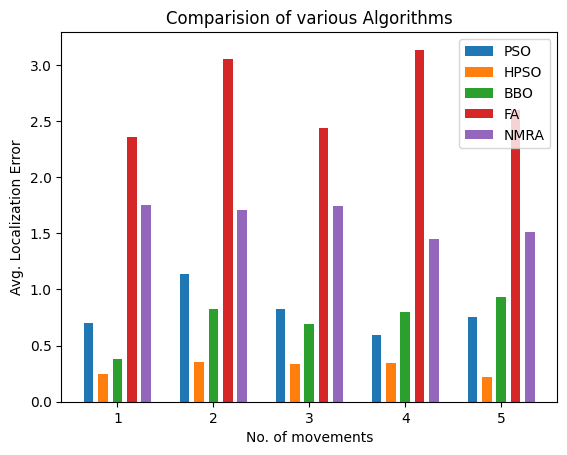

In [116]:
xaxis = np.arange(1,no_of_movements+1)
plt.bar(xaxis - 0.3, PSO_avg_error, 0.10, label = 'PSO')
plt.bar(xaxis - 0.15, HPSO_avg_error, 0.10, label = 'HPSO')
plt.bar(xaxis, BBO_avg_error, 0.10, label = 'BBO')
plt.bar(xaxis + 0.15, FA_avg_error, 0.10, label = 'FA')
plt.bar(xaxis + 0.3, avg_error, 0.10, label = 'ARO')
plt.legend()
plt.xlabel('No. of movements')
plt.ylabel('Avg. Localization Error')
plt.xticks(xaxis)
plt.title("Comparision of various Algorithms")
plt.show()

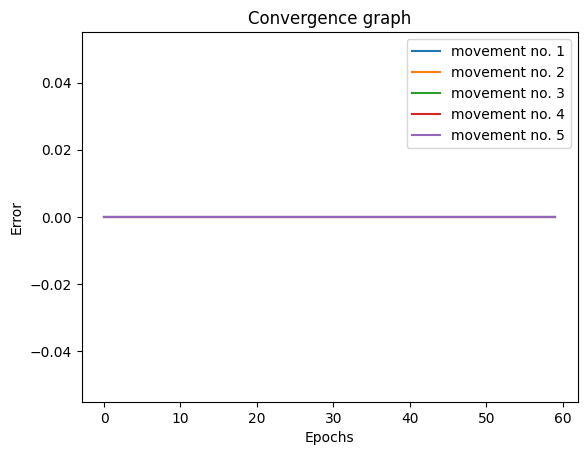

In [117]:
error_convergence = []

for i in range(len(error_overall)):
    temp = np.zeros(60)
    for j in range(len(error_overall[i])):
        for k in range(len(error_overall[i][j])):
            temp[k]+=error_overall[i][j][k]
        
    error_convergence.append(temp/len(error_overall[i]))


error_convergence = np.array(error_convergence)
# print(error_convergence)
xaxis = np.arange(1,61)

for i in range(len(error_convergence)):
    tis= "movement no. " + str(i+1)
    ax = sns.lineplot(error_convergence[i], label = tis)
    ax.set(xlabel="Epochs", ylabel = "Error", title = "Convergence graph")



In [118]:
x_axis=np.arange(1,6);
ax=sns.pointplot(x_axis,anchor_Energy,label='Amount of Energy')
ax.set(xlabel="Movement Number", ylabel = "Energy", title= "Energy vs Movement")

# plt.legend()

# plt.xlabel('No. of movements')
# plt.ylabel('Avg. Localization Error')
plt.show()

TypeError: pointplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 1 keyword-only argument) were given